# Final Project

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import libsvm
from libsvm import svmutil
from svmutil import svm_predict
from libsvm.svmutil import *
%matplotlib inline
import seaborn as sns
import time 
from scipy import stats
from datetime import datetime
import sklearn
from sklearn import preprocessing, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split

### Training data

In [2]:
# load training data
data = pd.read_csv('train.csv')
print(data.shape)

(9681, 25)


In [3]:
# see what features do we have
data.columns

Index(['id', 'neighbourhood', 'room_type', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'host_since',
       'host_is_superhost', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       'cleaning_fee', 'guests_included', 'extra_people', 'maximum_nights',
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'price'],
      dtype='object')

In [4]:
# drop id
data.drop(columns = 'id', inplace = True)

# change datetime to number of days from 10/8/2020
data['last_review'] = pd.to_datetime(data['last_review'])
data['host_since'] = pd.to_datetime(data['host_since'])
data['days_since_last_review'] = (datetime(2020, 10, 8) - data.last_review).astype('timedelta64[D]')
data['days_since_host'] = (datetime(2020, 10, 8) - data.host_since).astype('timedelta64[D]')
data.drop(columns=['last_review', 'host_since'], inplace = True)

# replace f/t with 0 and 1
data.replace({'f':0, 't':1}, inplace = True)

### Test data

In [5]:
# load test data
data_test =pd.read_csv('test.csv')

# replace f/t with 0 and 1
data_test.replace({'f':0, 't':1}, inplace = True)

# converting date to number
data_test['last_review'] = pd.to_datetime(data_test['last_review'])
data_test['host_since'] = pd.to_datetime(data_test['host_since'])
data_test['days_since_last_review'] = (datetime(2020, 10, 8) - data_test.last_review).astype('timedelta64[D]')
data_test['days_since_host'] = (datetime(2020, 10, 8) - data_test.host_since).astype('timedelta64[D]')
data_test.drop(columns=['last_review', 'host_since'], inplace = True)

# drop id
ID = data_test.id
data_test.drop(columns = ['id'], inplace = True)

### Distribution

In [6]:
print("Training data:", data.shape)
print('Test data:', data_test.shape)

Training data: (9681, 24)
Test data: (4149, 23)


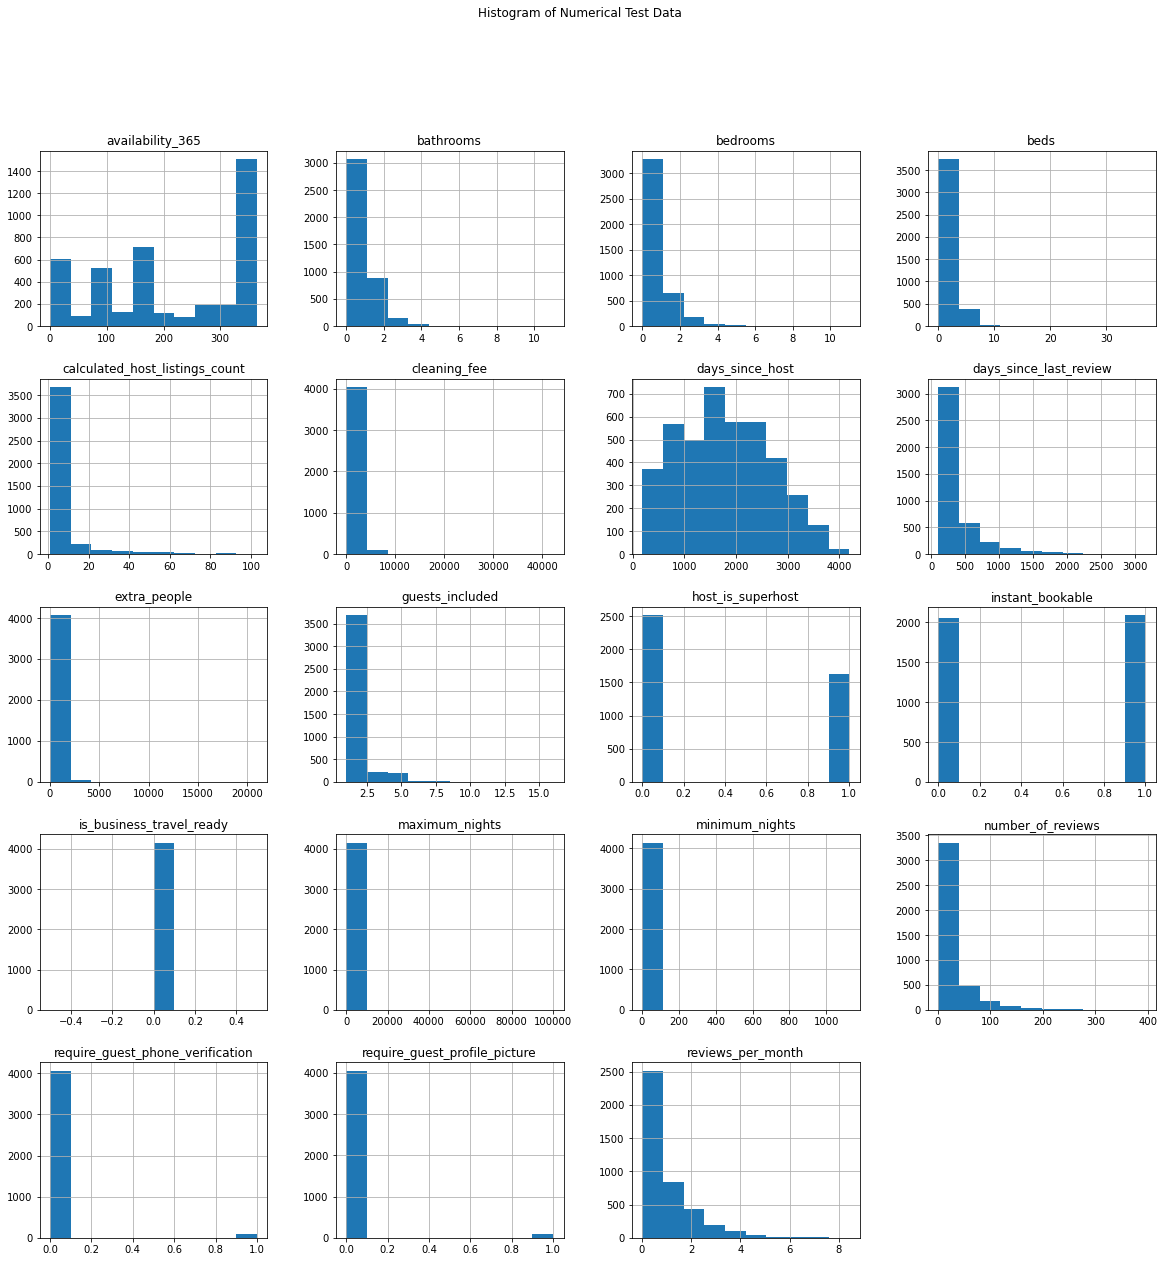

In [7]:
# a quick view of the test data
fig_t = data_test.hist(figsize  = (20,20))
plt.suptitle('Histogram of Numerical Test Data')
plt.savefig('test_his.png')

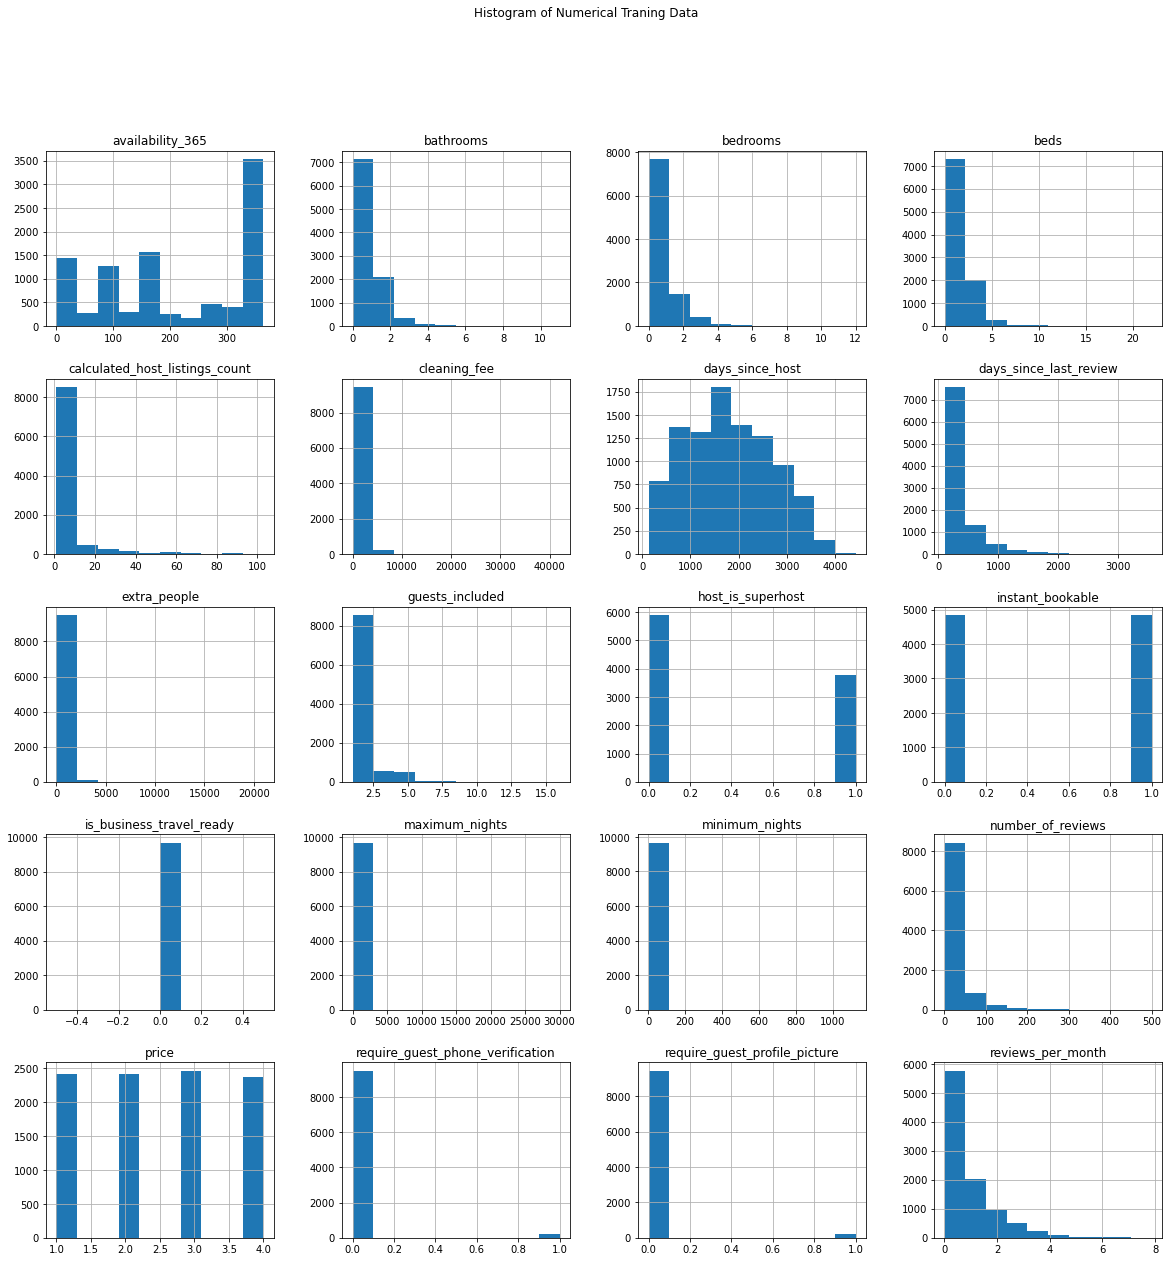

In [8]:
# a quick view of the training data
fig = data.hist(figsize  = (20,20))
plt.suptitle('Histogram of Numerical Traning Data')
plt.savefig('train_his.png')

### Features

#### Is_business_travel ready

In [9]:
# drop is_business_travel_ready
data.drop(columns = ['is_business_travel_ready'], inplace = True)
data_test.drop(columns = ['is_business_travel_ready'], inplace = True)

#### Bed type

In [10]:
# create table counts each type of bed and the average price of each type in training data
k = data['bed_type'].value_counts().to_frame()
k = k.rename(columns = {'bed_type': 'counts'})
a = data.groupby('bed_type').price.mean().to_frame()
k = k.join(a,lsuffix='_caller', rsuffix='_other')
k

,counts,price
Real Bed,9641,2.496836
Pull-out Sofa,23,2.652174
Futon,12,1.833333
Couch,3,2.000000
Airbed,2,1.000000


In [11]:
# create table counts each type of bed and the average price of each type in test data
k1 = data_test['bed_type'].value_counts().to_frame()
k1.rename(columns = {'bed_type': 'counts'})

,counts
Real Bed,4131
Pull-out Sofa,10
Futon,5
Airbed,3


In [12]:
# remove listings that have Couch as bed type in the training data
data = data[data.bed_type != 'Couch']
# re-create the table about type and prices
k = data['bed_type'].value_counts().to_frame()
k = k.rename(columns = {'bed_type': 'counts'})
a = data.groupby('bed_type').price.mean().to_frame()
k = k.join(a,lsuffix='_caller', rsuffix='_other')

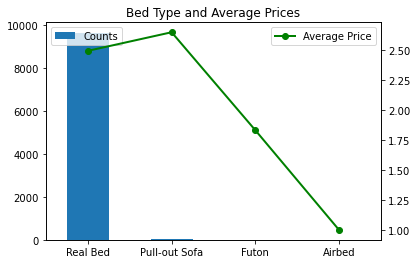

In [13]:
# plot bed type and average prices for each type in training data
fig = plt.figure()
ax = k['counts'].plot(kind='bar', use_index= True ,label = 'Counts')
ax2 = ax.twinx()
ax2.plot(ax.get_xticks(),
         k['price'],
         linestyle='-',
         marker='o',color = 'g', linewidth=2.0, label = 'Average Price')
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=0,
)
ax.legend(loc='upper left')
ax2.legend(loc = 'upper right')
ax.set_title('Bed Type and Average Prices')
plt.show()
fig.savefig('bedtype.png')

#### Room type

In [14]:
# create table counts each type of room and the average price of each type in training data
k = data['room_type'].value_counts().to_frame()
k = k.rename(columns = {'room_type': 'counts'})
a = data.groupby('room_type').price.mean().to_frame()
k = k.join(a,lsuffix='_caller', rsuffix='_other')
k

,counts,price
Entire home/apt,8363,2.663996
Private room,1183,1.402367
Shared room,67,1.104478
Hotel room,65,2.230769


In [15]:
# create table counts each type of room and the average price of each type in test data
k1 = data_test['room_type'].value_counts().to_frame()
k1.rename(columns = {'room_type': 'counts'})

,counts
Entire home/apt,3585
Private room,503
Shared room,32
Hotel room,29


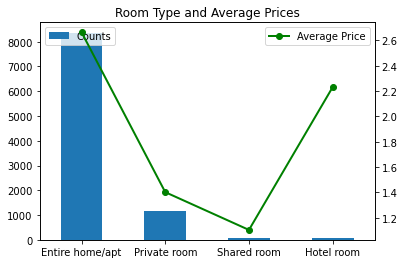

In [16]:
# plot room type and average prices for each type in training data
fig = plt.figure()
ax = k['counts'].plot(kind='bar', use_index= True ,label = 'Counts')
ax2 = ax.twinx()
ax2.plot(ax.get_xticks(),
         k['price'],
         linestyle='-',
         marker='o',color = 'g', linewidth=2.0, label = 'Average Price')
ax.legend(loc='upper left')
ax2.legend(loc = 'upper right')
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=0,
)
ax.set_title('Room Type and Average Prices')
plt.show()
fig.savefig('roomtype.png')

#### Cancellation policy

In [17]:
k = data['cancellation_policy'].value_counts().to_frame()
k = k.rename(columns = {'cancellation_policy': 'counts'})
a = data.groupby('cancellation_policy').price.mean().to_frame()
k = k.join(a,lsuffix='_caller', rsuffix='_other')
k

,counts,price
strict_14_with_grace_period,3394,2.659104
flexible,3160,2.344304
moderate,3095,2.462682
super_strict_30,26,3.500000
super_strict_60,3,3.666667


In [18]:
k1 = data_test['cancellation_policy'].value_counts().to_frame()
k1.rename(columns = {'cancellation_policy': 'counts'})

,counts
strict_14_with_grace_period,1464
moderate,1368
flexible,1313
super_strict_30,4


In [19]:
# remove listings in the training data that has super_strict_60 cancellation policy
data = data[data.cancellation_policy != 'super_strict_60']

# re-create the table about type and prices
k = data['cancellation_policy'].value_counts().to_frame()
k = k.rename(columns = {'cancellation_policy': 'counts'})
a = data.groupby('cancellation_policy').price.mean().to_frame()
k = k.join(a,lsuffix='_caller', rsuffix='_other')

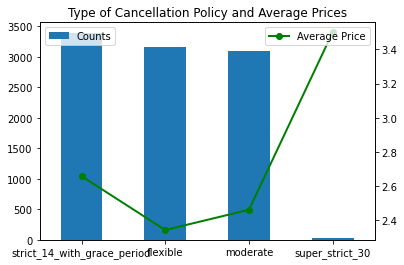

In [20]:
# plot type of cancellation policy and average prices for each type in the training data
fig = plt.figure(figsize = (6,4))
ax = k['counts'].plot(kind='bar', use_index= True ,label = 'Counts')
ax2 = ax.twinx()
ax2.plot(ax.get_xticks(),
         k['price'],
         linestyle='-',
         marker='o',color = 'g', linewidth=2.0, label = 'Average Price')
ax.legend(loc='upper left')
ax2.legend(loc = 'upper right')
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=0,
)
ax.set_title('Type of Cancellation Policy and Average Prices')
plt.show()
fig.savefig('cancel.png')

#### Neighbourhood

In [21]:
k = data['neighbourhood'].value_counts().to_frame()
k = k.rename(columns = {'neighbourhood': 'counts'})
a = data.groupby('neighbourhood').price.mean().to_frame()
k.join(a,lsuffix='_caller', rsuffix='_other')

,counts,price
Palermo,3299,2.791755
Recoleta,1660,2.685542
San Nicolás,595,2.265546
Retiro,495,2.602020
Belgrano,416,2.413462
Monserrat,390,2.243590
San Telmo,389,2.421594
Almagro,379,1.849604
Balvanera,365,1.939726
Villa Crespo,310,1.951613


In [22]:
k = data_test['neighbourhood'].value_counts().to_frame()
k.rename(columns = {'neighbourhood': 'counts'})

,counts
Palermo,1372
Recoleta,707
San Nicolás,247
Retiro,204
Belgrano,199
Balvanera,178
Monserrat,175
San Telmo,164
Almagro,153
Villa Crespo,148


In [23]:
# neighbourhoods not included in the test data
cols = []
for i in set(data["neighbourhood"]):
    if i not in set(data_test["neighbourhood"]):
        print(i)
        cols.append(i)

Vélez Sársfield
Villa Real
Mataderos


In [24]:
# remove listings in the training data that is in neighbourhoods above
data = data[data.neighbourhood != 'Mataderos']
data = data[data.neighbourhood != 'Vélez Sársfield']
data = data[data.neighbourhood != 'Villa Real']

In [25]:
print("Training data:", data.shape)
print('Test data:', data_test.shape)

Training data: (9664, 23)
Test data: (4149, 22)


In [26]:
# one-hot encoded categorical features
data_test = pd.get_dummies(data_test)
Xdata = pd.get_dummies(data)
print("Training data:", Xdata.shape)
print('Test data:', data_test.shape)

Training data: (9664, 73)
Test data: (4149, 72)


In [27]:
# seperate price from features
Y = Xdata.price
Xdata.drop(columns = 'price', inplace = True)
print("Training data:", Xdata.shape)

Training data: (9664, 72)


## Exploratory Analysis

In [28]:
# add prices in the last column for visualization 
Xdata['prices'] = Y

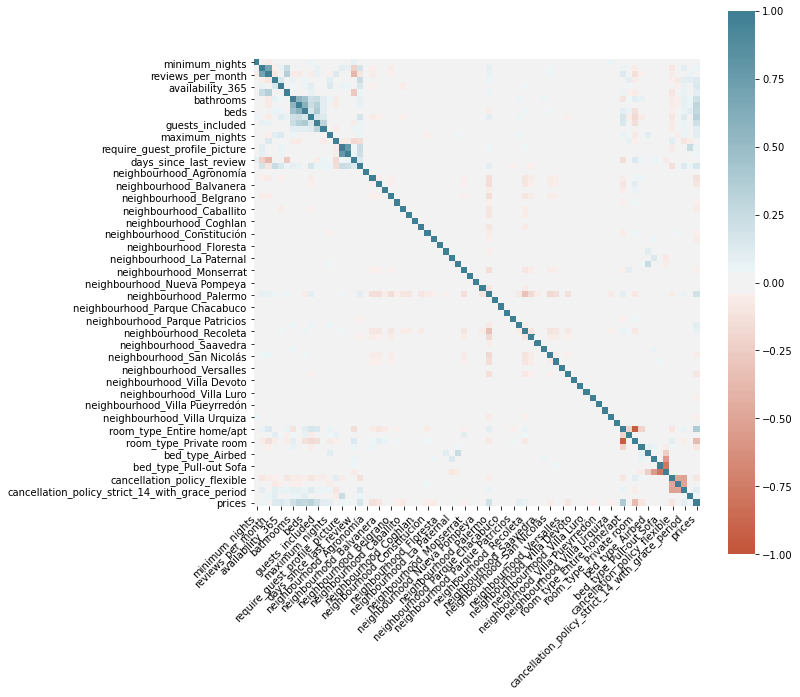

In [29]:
# create a correlation heatmap

corr = Xdata.corr()
fig = plt.figure(figsize = (10,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.show()

fig.savefig('heatmap.png')

In [30]:
# drop prices from the features
Xdata.drop(columns = 'prices', inplace = True)

### Neighbourhood

In [31]:
# Use the geojson file of the Buenos Aires neighbourhood
map_neighbour = gpd.read_file('neighbourhoods.geojson')
map_neighbour.drop(columns = ['neighbourhood_group'], inplace = True)

Source: http://insideairbnb.com/get-the-data.html

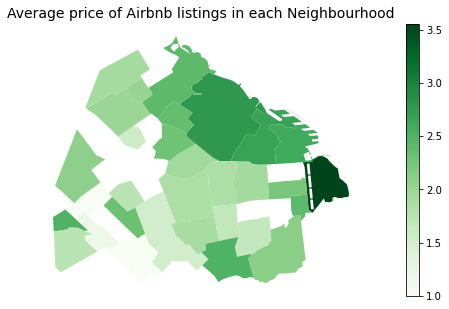

In [32]:
# create a dataframe with average prices and number of listings for each neighbourhood
n = pd.DataFrame(data.groupby('neighbourhood').size())
n.rename(columns={0: 'number_of_listings'}, inplace=True)
n['avg_price'] = data.groupby('neighbourhood').price.mean().values
n['median_price'] = data.groupby('neighbourhood').price.median().values
# combine the dataframe and the geo-map
n_map = map_neighbour.set_index('neighbourhood').join(n)

# Plot the average price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 5))
n_map.plot(column='avg_price', cmap='Greens', ax=ax2)
ax2.axis('off')
ax2.set_title('Average price of Airbnb listings in each Neighbourhood', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=min(n_map.median_price), 
                                                            vmax=max(n_map.avg_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()
fig2.savefig('neigh.png')

# Models

### Prepare data for training

In [33]:
# scale features
scaler = preprocessing.StandardScaler()
# scale training data
X = pd.DataFrame(scaler.fit_transform(Xdata), columns=list(Xdata.columns))
# scale test data
X_test = pd.DataFrame(scaler.fit_transform(data_test), columns=list(data_test.columns))

In [34]:
X.head()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,host_is_superhost,bathrooms,bedrooms,beds,cleaning_fee,...,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30
0,-0.195658,3.984677,1.532531,-0.145142,0.992381,1.247643,-0.438704,-1.383005,-0.663041,0.386720,...,-0.372761,-0.083554,-0.014387,-0.03526,-0.048843,0.061995,-0.695886,-0.685916,1.359491,-0.051939
1,-0.195658,-0.353632,-0.370085,-0.386370,-1.574888,1.247643,-0.438704,-0.164427,-0.663041,-0.532227,...,2.682681,-0.083554,-0.014387,-0.03526,-0.048843,0.061995,-0.695886,1.457904,-0.735569,-0.051939
2,-0.104399,-0.599196,-0.858190,1.060994,1.096259,-0.801511,-0.438704,-1.383005,-0.663041,-0.236295,...,-0.372761,-0.083554,-0.014387,-0.03526,-0.048843,0.061995,-0.695886,1.457904,-0.735569,-0.051939
3,-0.150029,-0.626481,-0.808384,-0.386370,0.406212,-0.801511,-0.438704,-0.164427,0.802900,-0.866498,...,-0.372761,-0.083554,-0.014387,-0.03526,-0.048843,0.061995,1.437017,-0.685916,-0.735569,-0.051939
4,-0.150029,0.192068,0.596165,-0.064733,1.133358,1.247643,-0.438704,-0.164427,0.802900,0.386720,...,-0.372761,-0.083554,-0.014387,-0.03526,-0.048843,0.061995,-0.695886,1.457904,-0.735569,-0.051939


In [35]:
# define cross validation folds: 5-folds cross validation
kf = KFold(n_splits = 5, shuffle=True, random_state = 15)

In [36]:
# define a function that plots cross validation results and save the plot
def plot_cross_validation_results(depths, cv_scores_mean, 
                                   cv_scores_std, title):
    fig, ax = plt.subplots(1,1, figsize=(20,5))
    ax.plot(depths, cv_scores_mean, '-o', 
            label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, 
                    cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Maximum Tree depth', fontsize=14)
    ax.set_xticks(depths)
    ax.legend()
    fig.savefig(title + '.png')

## Random Forest

### All Features

#### Tuning max_depth

In [54]:
# define a function that runs cross validation on trees
def cross_val_trees(x, y, kf, depths):
    
    """
    
    This function runs cross validation on random forest with differnt max_depth, given cross validation split
    Input: x - data, y - label, kf - k fold cv spliting, depths - range of max_depth
    Output: mean cross validation accuracy, cross validation standard deviation, run time of this function
    
    """
    
    # record run time
    start = time.time()
    
    cv_scores_mean, cv_scores_std = [], []
    
    for depth in depths:
        clf = RandomForestClassifier(n_estimators=2000, criterion='entropy', max_depth = depth, oob_score = True,
                                     random_state=0,verbose=0)
        scores_clf = cross_val_score(clf, x, y, scoring='accuracy', cv=kf)
        
        # cv results
        cv_scores_mean.append(scores_clf.mean())
        cv_scores_std.append(scores_clf.std())
        print(depth, scores_clf.mean())
    
    
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    
    run_time = time.time()-start
    
    return cv_scores_mean, cv_scores_std, run_time

In [55]:
# possible max_depth
depths = range(1,30)

In [56]:
# run the cross validation function
rdf_mean, rdf_std, rdf_time = cross_val_trees(X, Y, kf, depths)
print(rdf_time)

1 0.48085775122932956
2 0.48748038588790743
3 0.4912049518068547
4 0.5002074677685916
5 0.5033122545223583
6 0.5132461797332801
7 0.5219378689193575
8 0.5287679177926371
9 0.5324930192504812
10 0.5361149759168158
11 0.5399437041511762
12 0.5428413444596896
13 0.5466696442629324
14 0.5502911189442601
15 0.550084561591793
16 0.5504989615900792
17 0.5479116125183288
18 0.5513258872005132
19 0.5513264762932997
20 0.5518435390980883
21 0.5524644428949519
22 0.5526715357863157
23 0.5502911724981497
24 0.5507053047269876
25 0.550808770841835
26 0.5481188660713616
27 0.5495668561403283
28 0.5502916544831568
29 0.5511196511713843
3469.4145352840424


<Figure size 432x288 with 0 Axes>

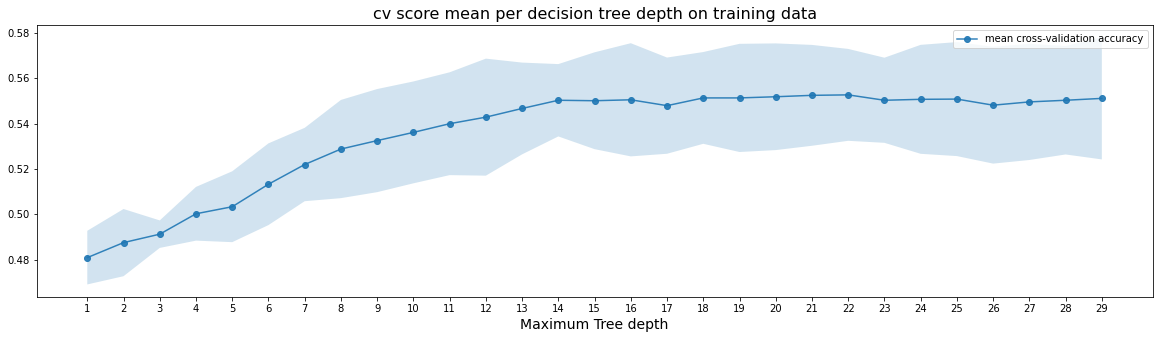

In [57]:
# plot the cv score mean for each max_depth
fig = plt.figure()
plot_cross_validation_results(depths, rdf_mean, rdf_std, 
                               'cv score mean per decision tree depth on training data')
plt.show()

In [77]:
# choose the best max_depth and train on the whole trainging set
max_dep = 22
s = time.time()
clf_rdf = RandomForestClassifier(n_estimators=2000, criterion='gini', max_depth = max_dep, random_state=0)
clf_rdf.fit(X, Y)
print('training acc:', clf_rdf.score(X, Y), 'time:', time.time()-s)

training acc: 0.9995860927152318 time: 27.356616020202637


#### Tuning n_estimators

In [82]:
# define a function that runs cross validation on trees
def cross_val_trees_nestimator(x, y, kf, n):
    
    """
    
    This function runs cross validation on random forest with differnt n_estimators, given cross validation split
    Input: x - data, y - label, kf - k fold cv spliting, depths - range of max_depth
    Output: mean cross validation accuracy, cross validation standard deviation, run time of this function
    
    """
    
    # record run time
    start = time.time()
    
    cv_scores_mean, cv_scores_std = [], []
    
    for num in n:
        clf = RandomForestClassifier(n_estimators=num, criterion='entropy', max_depth = 22, oob_score = True,
                                     random_state=0,verbose=0)
        scores_clf = cross_val_score(clf, x, y, scoring='accuracy', cv=kf)
        
        # cv results
        cv_scores_mean.append(scores_clf.mean())
        cv_scores_std.append(scores_clf.std())
        print(depth, scores_clf.mean())
    
    
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    
    run_time = time.time()-start
    
    return cv_scores_mean, cv_scores_std, run_time

In [84]:
# possible number of trees in the forest
n = [100, 500, 1000, 1500, 2000]
# run the cross validation function
rdf_n_mean, rdf_n_std, rdf_n_time = cross_val_trees(X, Y, kf, n)
print(rdf_n_time)

100 0.5493599239106335
500 0.5493599239106335
1000 0.5493599239106335
1500 0.5493599239106335
2000 0.5493599239106335
703.7198657989502


### Feature importances

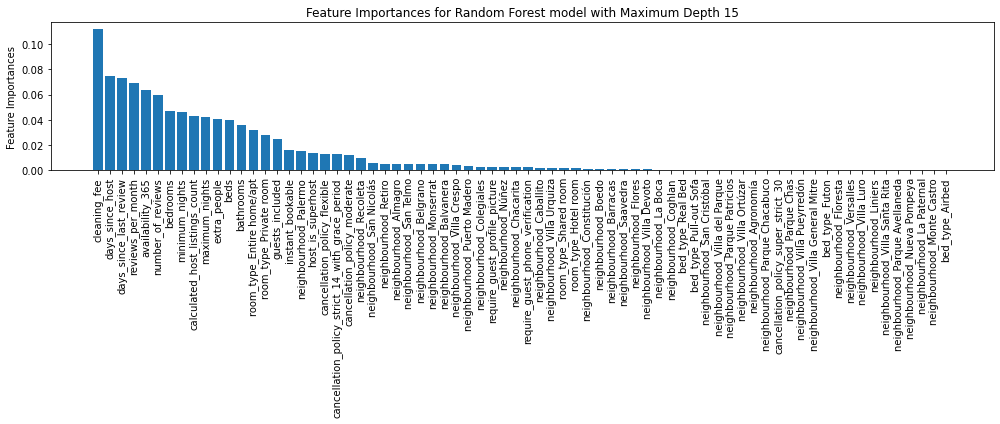

In [61]:
# sort the importances from high to low and  plot importance for each feature
imp=[]
for i,j in zip(X.columns, range(len(clf_rdf.feature_importances_))):
    imp.append((i,clf_rdf.feature_importances_[j]))
imp.sort(key = lambda x: -x[1]) 

fig = plt.figure(figsize = (14,6))
plt.bar([x[0] for x in imp], np.abs([x[1] for x in imp]))
plt.xticks(rotation=90)
plt.title('Feature Importances for Random Forest model with Maximum Depth 15')
plt.ylabel('Feature Importances')
plt.tight_layout() # make room for xlabels
plt.show()
fig.savefig('feature_importances_rdf.png')

In [62]:
# drop features which importance is less than 0.01
delfe = []
for i in range(len(X.columns)):
    if clf_rd.feature_importances_[i]<0.01:
        delfe.append(X.columns[i])

new_X = X.copy()
new_X.drop(columns = delfe, inplace = True)

In [63]:
new_X.shape

(9664, 22)

In [65]:
# run cross validation on the selected features

# possible max_depth
new_depths = range(10,25)

# run the cross validation function
new_rdf_mean, new_rdf_std, new_rdf_time = cross_val_trees(new_X, Y, kf, new_depths)
print(new_rdf_time)

10 0.5387013610185521
11 0.5404607669559647
12 0.5451170634474353
13 0.5457380743520783
14 0.5469799890535849
15 0.5447039487425012
16 0.5463591923645007
17 0.5487392343293286
18 0.5458412726974773
19 0.546979667730247
20 0.5479108627638734
21 0.5453245312160268
22 0.5483253698699391
23 0.547911076979432
24 0.5464624442637893
1837.7601029872894


<Figure size 432x288 with 0 Axes>

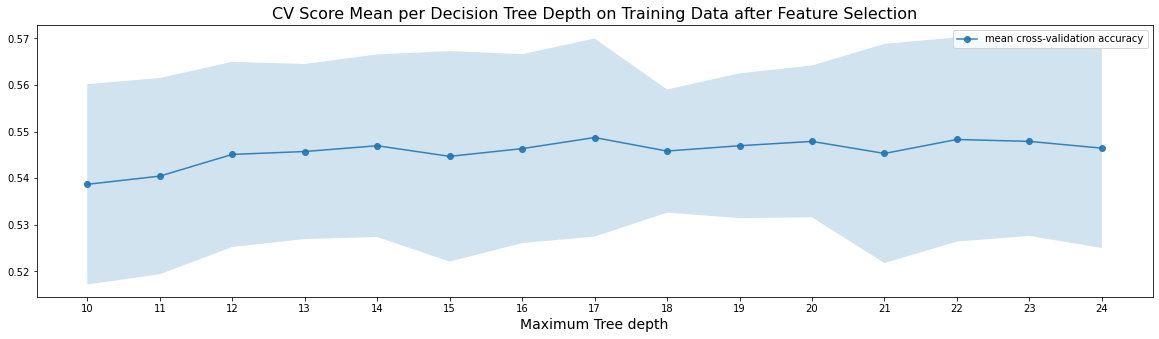

In [66]:
# plot the cv score mean for each max_depth
fig = plt.figure()
plot_cross_validation_results(new_depths, new_rdf_mean, new_rdf_std, 
                               'CV Score Mean per Decision Tree Depth on Training Data after Feature Selection')
plt.show()


## CNN

In [37]:
import tensorflow as tf
import keras
from tensorflow.python.keras import backend as K
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


In [38]:
# define a function that reset tensorflow session
def reset_tf_session():
    """
    A function that clears tf session/graph
    """
    curr_session = tf.compat.v1.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.compat.v1.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [39]:
# one-hot encode price levels
Y_oh = pd.get_dummies(Y)
print("Train samples:", X.shape, Y_oh.shape)

Train samples: (9664, 72) (9664, 4)


In [40]:
# split data into training and validation set
X_tr, X_val, Y_tr, Y_val = train_test_split(X, Y_oh, test_size=0.2, shuffle = True)
X_tr = X_tr.to_numpy()
X_val = X_val.to_numpy()
Y_tr = Y_tr.to_numpy()
Y_val = Y_val.to_numpy()
# add 1 dim to the array
X_tr=np.expand_dims(X_tr,axis=1)
X_val=np.expand_dims(X_val,axis=1)

### Learning Rate

In [43]:
# define possible learning rate
eta = [5e-4, 1e-3, 5e-3, 0.01, 0.05, 0.1]

In [44]:
# first try relu as activation function
def make_cnnmodel():
    """
    Define the model architecture.
    
    """
    model = Sequential()
    
    model.add(Conv1D(filters = 16, kernel_size = 3, padding = 'same', input_shape=(1,72)))
    model.add(Activation('relu'))
    model.add(Conv1D(filters = 32, kernel_size = 3, padding = 'same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))


    model.add(Flatten(input_shape=(1,72)))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.25))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.25))
    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.25))
    model.add(Dense(4))
    model.add(Activation('softmax'))
    
    return model

In [57]:
# store results
val_acc_lr = []
start = time.time()
for e in eta:
    # initial learning rate
    init_lr = e  
    batch = 128
    epoch = 50

    # clear default graph
    s = reset_tf_session() 

    # define the model
    model = make_cnnmodel()  

    # prepare model for fitting 
    model.compile(
        loss='categorical_crossentropy',  # train 4-way classification
        optimizer=keras.optimizers.adamax(lr = init_lr),  
        metrics=['accuracy']  # report accuracy during training
    )
    
    # fit the model
    model.fit(
    X_tr, Y_tr,  
    batch_size = batch,
    epochs = epoch,
    validation_data=(X_val, Y_val),
    shuffle=True,
    verbose=0,
    initial_epoch=0
    )
    
    # get validation results
    val = model.history.history['val_accuracy']
    val_acc_lr.append(val)
t = time.time()-start
print('run time:', t)

run time: 362.9908571243286


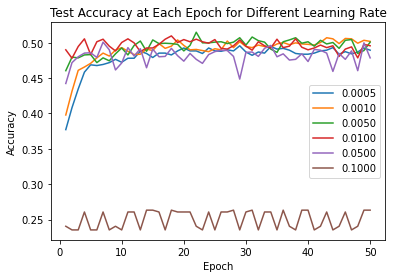

In [58]:
# plot the result
fig = plt.figure()
for i in range(len(eta)):
    plt.plot(range(1,epoch+1), val_acc_lr[i], label = '%.4f'%eta[i])

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Test Accuracy at Each Epoch for Different Learning Rate')
plt.show()
fig.savefig('Learning Rate.png')

### Activation functions

#### ReLu 

In [59]:
# describe model
s = reset_tf_session() 
model = make_cnnmodel()

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1, 16)             3472      
_________________________________________________________________
activation_1 (Activation)    (None, 1, 16)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 32)             1568      
_________________________________________________________________
activation_2 (Activation)    (None, 1, 32)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)              

In [60]:
# initial learning rate
init_lr = 5e-3  
batch = 128
epoch = 50

# clear default graph
s = reset_tf_session() 

# define the model
model = make_cnnmodel()  

# prepare model for fitting 
model.compile(
    loss='categorical_crossentropy',  # train 4-way classification
    optimizer=keras.optimizers.adamax(lr = init_lr),  
    metrics=['accuracy']  # report accuracy during training
)

In [61]:
# fit the model
start = time.time()
model.fit(
    X_tr, Y_tr,  
    batch_size = batch,
    epochs = epoch,
    validation_data=(X_val, Y_val),
    shuffle=True,
    verbose=0,
    initial_epoch=0
)
end = time.time()
cnn_time = end - start # record the run time

In [62]:
print('run time:', cnn_time)

run time: 62.177632093429565


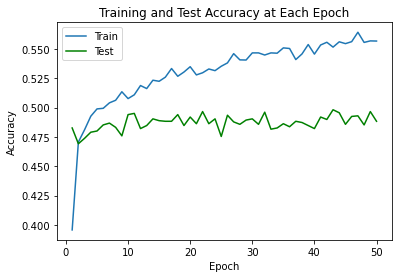

In [63]:
# plot training and validation accuracy

model_results = model.history.history
fig = plt.figure()
plt.plot(range(1,epoch+1), model_results['accuracy'], label='Train')
plt.plot(range(1,epoch+1), model_results['val_accuracy'], label='Test', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Test Accuracy at Each Epoch')
plt.show()
fig.savefig('Training and Test Accuracy at Each Epoch.png')

#### Sigmoid

In [64]:
def make_cnnmodel_sig():
    """
    Define the model architecture.
    
    """
    model = Sequential()
    
    model.add(Conv1D(filters = 16, kernel_size = 3, padding = 'same', input_shape=(1,72)))
    model.add(Activation('sigmoid'))
    model.add(Conv1D(filters = 32, kernel_size = 3, padding = 'same'))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.25))


    model.add(Flatten(input_shape=(1,72)))
    model.add(Dense(128, activation = 'sigmoid'))
    model.add(Dropout(0.25))
    model.add(Dense(256, activation = 'sigmoid'))
    model.add(Dropout(0.25))

    model.add(Dense(512, activation = 'sigmoid'))
    model.add(Dropout(0.25))
    model.add(Dense(4))
    model.add(Activation('softmax'))
    
    return model

In [65]:
# initial learning rate
init_lr = 5e-3  
batch = 128
epoch = 50

# clear default graph
s = reset_tf_session() 

# define the model
model_1 = make_cnnmodel_sig()  

# prepare model for fitting 
model_1.compile(
    loss='categorical_crossentropy',  # train 4-way classification
    optimizer=keras.optimizers.adamax(lr = init_lr),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# fit the model
start = time.time()
model_1.fit(
    X_tr, Y_tr,  
    batch_size = batch,
    epochs = epoch,
    validation_data=(X_val, Y_val),
    shuffle=True,
    verbose=0,
    initial_epoch=0
)
end = time.time()
cnn_time_1 = end - start # record the run time

#### Tanh

In [66]:
def make_cnnmodel_tanh():
    """
    Define the model architecture.
    
    """
    model = Sequential()
    
    model.add(Conv1D(filters = 16, kernel_size = 3, padding = 'same', input_shape=(1,72)))
    model.add(Activation('tanh'))
    model.add(Conv1D(filters = 32, kernel_size = 3, padding = 'same'))
    model.add(Activation('tanh'))
    model.add(Dropout(0.25))


    model.add(Flatten(input_shape=(1,72)))
    model.add(Dense(128, activation = 'tanh'))
    model.add(Dropout(0.25))
    model.add(Dense(256, activation = 'tanh'))
    model.add(Dropout(0.25))
    model.add(Dense(512, activation = 'tanh'))
    model.add(Dropout(0.25))
    model.add(Dense(4))
    model.add(Activation('softmax'))
    
    return model

In [67]:
# initial learning rate
init_lr = 5e-3  
batch = 128
epoch = 50

# clear default graph
s = reset_tf_session() 

# define the model
model_2 = make_cnnmodel_tanh()  

# prepare model for fitting 
model_2.compile(
    loss='categorical_crossentropy',  # train 4-way classification
    optimizer=keras.optimizers.adamax(lr = init_lr),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# fit the model
start = time.time()
model_2.fit(
    X_tr, Y_tr,  
    batch_size = batch,
    epochs = epoch,
    validation_data=(X_val, Y_val),
    shuffle=True,
    verbose=0,
    initial_epoch=0
)
end = time.time()
cnn_time_2 = end - start # record the run time

#### elu

In [68]:
def make_cnnmodel_elu():
    """
    Define the model architecture.
    
    """
    model = Sequential()
    
    model.add(Conv1D(filters = 16, kernel_size = 3, padding = 'same', input_shape=(1,72)))
    model.add(Activation('elu'))
    model.add(Conv1D(filters = 32, kernel_size = 3, padding = 'same'))
    model.add(Activation('elu'))
    model.add(Dropout(0.25))


    model.add(Flatten(input_shape=(1,72)))
    model.add(Dense(128, activation = 'elu'))
    model.add(Dropout(0.25))
    model.add(Dense(256, activation = 'elu'))
    model.add(Dropout(0.25))
    model.add(Dense(512, activation = 'elu'))
    model.add(Dropout(0.25))
    model.add(Dense(4))
    model.add(Activation('softmax'))
    
    return model

In [69]:
# initial learning rate
init_lr = 5e-3  
batch = 128
epoch = 50

# clear default graph
s = reset_tf_session() 

# define the model
model_3 = make_cnnmodel_elu()  

# prepare model for fitting 
model_3.compile(
    loss='categorical_crossentropy',  # train 4-way classification
    optimizer=keras.optimizers.adamax(lr = init_lr),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# fit the model
start = time.time()
model_3.fit(
    X_tr, Y_tr,  
    batch_size = batch,
    epochs = epoch,
    validation_data=(X_val, Y_val),
    shuffle=True,
    verbose=0,
    initial_epoch=0
)
end = time.time()
cnn_time_3 = end - start # record the run time

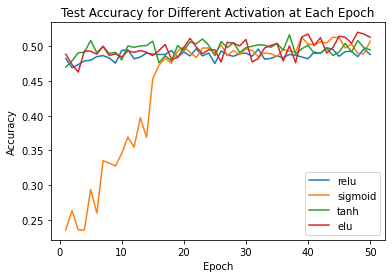

In [70]:
# plot the results for activation functions
results = model.history.history
results_1 = model_1.history.history
results_2 = model_2.history.history
results_3 = model_3.history.history
fig = plt.figure()
plt.plot(range(1,epoch+1), results['val_accuracy'], label='relu')
plt.plot(range(1,epoch+1), results_1['val_accuracy'], label='sigmoid')
plt.plot(range(1,epoch+1), results_2['val_accuracy'], label='tanh')
plt.plot(range(1,epoch+1), results_3['val_accuracy'], label='elu')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Test Accuracy for Different Activation at Each Epoch')
plt.show()
fig.savefig('Test Accuracy for Different Activation at Each Epoch.png')

In [71]:
# total time for tuning 
cnn_time + cnn_time_1 + cnn_time_2 + cnn_time_3

272.16894793510437

### Run the whole training set

In [73]:
# preprocess the data
Y_cnn = Y_oh.to_numpy()
X_cnn = X.to_numpy()
# add 1 dim to the array
X_cnn=np.expand_dims(X_cnn,axis=1)

In [75]:
# initial learning rate
init_lr = 5e-3  
batch = 128
epoch = 50

# clear default graph
s = reset_tf_session() 

# define the model
model = make_cnnmodel()  

# prepare model for fitting 
model.compile(
    loss='categorical_crossentropy',  # train 4-way classification
    optimizer=keras.optimizers.adamax(lr = init_lr),  
    metrics=['accuracy']  # report accuracy during training
)
# fit the model
start = time.time()
model.fit(
    X_cnn, Y_cnn,  
    batch_size = batch,
    epochs = epoch,
    shuffle=True,
    verbose=0,
    initial_epoch=0
)
end = time.time()
cnn_time = end - start # record the run time

print('run time:', cnn_time)

run time: 69.4025490283966


# Prediction

In [80]:
# use test data to make prediction 
pred_rdf = pd.DataFrame({'price':clf_rdf.predict(X_test)})
ID = pd.DataFrame(ID)
pred = ID.join(pred_rdf,lsuffix='_caller', rsuffix='_other')
pred = pred.set_index('id')
display(pred)

,price
id,
7715,2
13196,2
13194,2
4673,2
11325,1
...,...
12921,3
7174,2
9240,3


In [81]:
# save to csv file
pred.to_csv('pred.csv')